In [1]:
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statannot

# Visualization

This Jupyter Notebook shows the code to make all plots in the acompanying thesis. Alterations were only performed to make graphs more visually appealing or to add numerical data (e.g. number of samples).

All figures are divided into two sections:
- Preprocessing: data is read from csv files and made accessible to plot. This also includes filtering steps to remove outliers or focus in on the data that should be presented.
- Plotting: displaying of data. Usually divided into the sections style (high level visual settings), plot (the actual data display), statistics (addition of statistical significancies if applicable), display (minor visual tweaks e.g. adding axes labeling), and saving.

All data is stored in the `data` subdirectory and plots are saved to `plots`.

© Bastian Th. Eichenberger, 2020. All rights reserved.

## Figure 2 – MCP SG Content

Part of the MCP vs. MCPG3 comparison. Compares the mRNA fraction localized to stress granules.

**Processing**

In [2]:
def find_condition(file):
    if 'sMHG3_' in file:
        return 'MCPG3'
    return 'MCP'

In [3]:
# Reading
df = pd.read_csv(f'./data/MCP_SGs.csv', index_col=0)

# Rearangement
df['condition'] = df['file'].apply(lambda x: find_condition(x))

# Filtering
df = df[(df['nuclear'] == False)]
df['count'] = df.groupby(['file', 'cell'])['coord_x'].transform('count')
df = df[(df['count'] < 50)]

df['granular'] = df['granule'] > 7000
df['avg'] = df.groupby(['file', 'cell'])['granular'].transform('mean')

print(f"Used – {df[df['condition'] == 'MCP']['cell'].nunique()} MCP cells.")
print(f"Used – {df[df['condition'] == 'MCPG3']['cell'].nunique()} MCPG3 cells.")

Used – 27 MCP cells.
Used – 21 MCPG3 cells.


**Plotting**

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MCP v.s. MCPG3: t-test independent samples, P_val=5.018e-52 stat=-1.616e+01


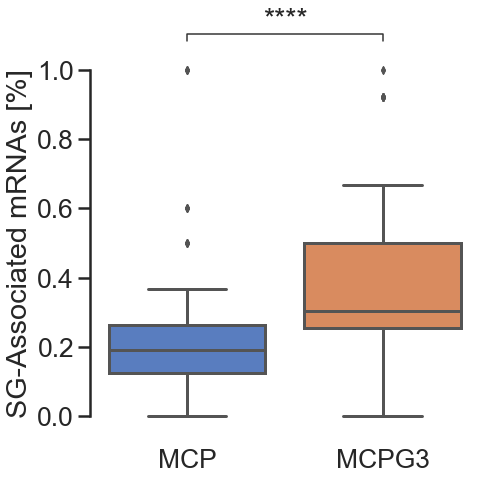

In [4]:
df_plot = df

# Style
sns.set(context='poster', font='Arial', font_scale=1.2, style='whitegrid', palette='muted')
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.boxplot(x='condition',
                 y='avg',
                 order=['MCP', 'MCPG3'],
                 data=df_plot)

# Statistics
statannot.add_stat_annotation(ax, data=df_plot,
                              x='condition', y='avg',
                              boxPairList=[('MCP', 'MCPG3')],
                              test='t-test_ind', loc='outside', verbose=1, stack=False)

# Display
ax.set_xlabel('')
ax.set_ylabel('SG-Associated mRNAs [%]')
ax.tick_params(bottom=False)
sns.despine(left=False, bottom=True, trim=True)

# Saving
plt.savefig('./plots/MCP_SGs.pdf', bbox_inches='tight')
plt.show()

## Figure 3 – MCP Luciferase

Ctd. Luciferase assays during induction and arsenite stress recovery.

**Processing**

In [5]:
# Reading
columns = ['cell', 'date', 'experiment', 'condition', 'replicate',
           'luciferase', 'bradford']
df = pd.read_csv('./data/MCP_Luciferase.csv', header=0, sep=',', names=columns)
df = df.reset_index(drop=True)

# Normalization
for d in df.date.unique():
    # Water normalization
    water_luci = df[(df.cell == 'Water') &
                    (df.date == d)]\
                    ['luciferase']\
                    .mean()
    df['luciferase_n'] = df['luciferase'] - water_luci

    # Bradford normalization
    water_brad = df[(df.cell == 'Water') &
                    (df.date == d)]\
                    ['bradford']\
                    .mean()
    df['bradford_n'] = df['bradford'] - water_brad
    
    # Baseline / mean normalization
    baseline_index = list(df[(df.date == d) &
                             (df.cell == 'MCP') &
                             (df.condition == '3')].index)
    normalized = df['luciferase_n']/df['bradford_n']
    baseline = normalized.iloc[baseline_index].mean(skipna=True)
    df['normalized'] = normalized / baseline
    
# Filtering
df_induction = df[(df.experiment == 'Induction') & (df.cell != 'Water')]
df_recovery = df[(df.experiment != 'Induction') & (df.cell != 'Water')]

**Plotting**

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2_MCP v.s. 2_MCPG3: t-test independent samples, P_val=2.648e-04 stat=-5.492e+00
3_MCP v.s. 3_MCPG3: t-test independent samples, P_val=1.130e-10 stat=-1.136e+01


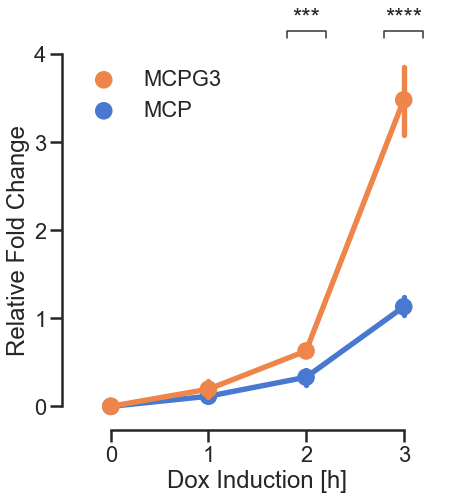

In [6]:
# Induction
df_plot = df_induction

# Style
sns.set(context='poster', font='Arial', style='white', palette='muted')
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.pointplot(x='condition',
                 y='normalized',
                 hue='cell',
                 data=df_plot)

# Statistics
statannot.add_stat_annotation(ax, data=df_plot,
                              x='condition', y='normalized', hue='cell',
                              boxPairList=[(('2', 'MCP'), ('2', 'MCPG3')),
                                           (('3', 'MCP'), ('3', 'MCPG3'))],
                              test='t-test_ind', loc='outside', verbose=1, stack=False)


# Display
ax.set_xlabel('Dox Induction [h]')
ax.set_ylabel('Relative Fold Change')
ax.set_yticks(np.arange(0, 5, 1))
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc='upper left')
sns.despine(left=False, bottom=False, trim=True)

# Saving
plt.savefig('./plots/MCP_Luciferase_Ind.pdf', bbox_inches='tight')
plt.show()

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1_MCP v.s. 1_MCPG3: t-test independent samples, P_val=4.983e-02 stat=-2.076e+00
2_MCP v.s. 2_MCPG3: t-test independent samples, P_val=4.475e-03 stat=-3.166e+00


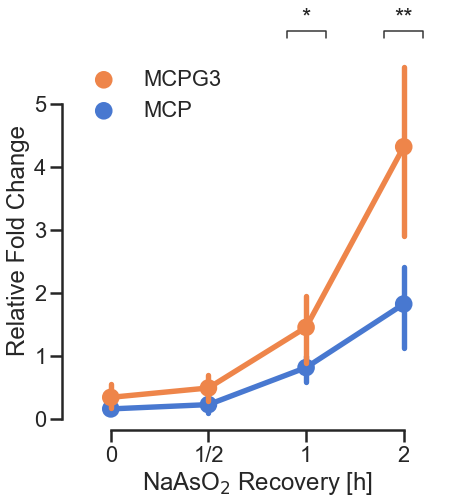

In [7]:
# Recovery
df_plot = df_recovery

# Style
sns.set(context='poster', font='Arial', style='white', palette='muted')
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.pointplot(x='condition',
                   y='normalized',
                   hue='cell',
                   data=df_plot)

# Statistics
statannot.add_stat_annotation(ax, data=df_plot,
                              x='condition', y='normalized', hue='cell',
                              boxPairList=[(('1', 'MCP'), ('1', 'MCPG3')),
                                           (('2', 'MCP'), ('2', 'MCPG3'))],
                              test='t-test_ind', loc='outside', verbose=1, stack=False)

# Display
ax.set_xlabel('NaAsO$_2$ Recovery [h]')
ax.set_xticklabels(['0', '1/2', '1', '2'])
ax.set_ylabel('Relative Fold Change')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc='upper left')
sns.despine(left=False, bottom=False, trim=True)

# Saving
plt.savefig('./plots/MCP_Luciferase_Rec.pdf', bbox_inches='tight')
plt.show()

## Figure 4 – MCP SunTag

Ctd. SunTag live cell imaging assay with normal induction or after 15 minutes of arsenite stress recovery.

**Processing**

In [8]:
# Cellular basis

# Reading
files = glob.glob('./data/MCP*_cells.xlsx')
df = pd.concat((pd.read_excel(f, header=0) for f in files), sort=False, ignore_index=True)

# Rearangement
df['induction'] = df['cell'].apply(lambda x: 'Dox' if '_Dox_' in x else 'DoxArs')
df['condition'] = df['cell'].apply(lambda x: 'MCP-G3BP1' if 'sMHG3' in x else 'MCP')
mean = df[(df['induction'] == 'Dox') & (df['condition'] == 'MCP')]['Mean_Track_int_PerCell'].mean()
df['rel_track'] = df['Mean_Track_int_PerCell'] / mean

print(df.groupby(['condition', 'induction']).count()['cell'])

df_cells = df

condition  induction
MCP        Dox          48
           DoxArs       77
MCP-G3BP1  Dox          31
           DoxArs       48
Name: cell, dtype: int64


In [9]:
# Image basis

# Reading
files = glob.glob('./data/*_all.xlsx')
df = pd.concat((pd.read_excel(f, header=0) for f in files), sort=False, ignore_index=True)

# Rearangement
df['induction'] = df['file'].apply(lambda x: 'Dox' if '_Dox_' in x else 'DoxArs')
df['condition'] = df['file'].apply(lambda x: 'MCP-G3BP1' if 'sMHG3' in x else 'MCP')
mean = df[(df['induction'] == 'Dox') & (df['condition'] == 'MCP')]['Mean_Int_Green'].mean()
df['rel_track'] = df['Mean_Int_Green'] / mean

print(df.groupby(['condition', 'induction']).count()['file'])

df_images = df

condition  induction
MCP        Dox           715
           DoxArs       1064
MCP-G3BP1  Dox           997
           DoxArs       3442
Name: file, dtype: int64


**Plotting**

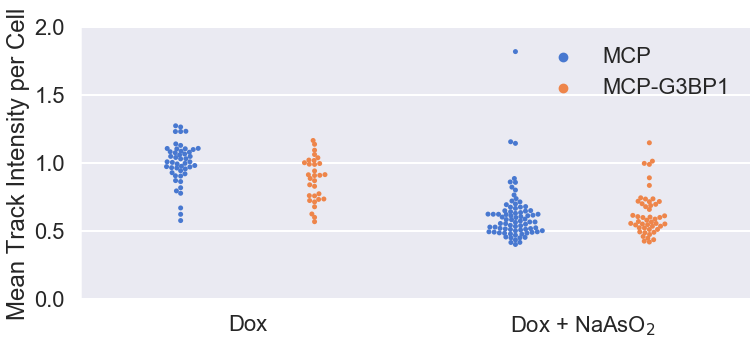

In [10]:
# Cellular Intensity
df_plot = df_cells

# Style
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})
sns.set(context='poster', font='Arial', style='darkgrid', palette='muted')

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.swarmplot(x='induction',
                   y='rel_track',
                   hue='condition',
                   dodge=True,
                   data=df_plot,
                   order=['Dox', 'DoxArs'],
                   hue_order=['MCP', 'MCP-G3BP1'])

# Display
ax.set(xlabel='', ylabel='Mean Track Intensity per Cell')
ax.set_xticklabels(['Dox', 'Dox + NaAsO$_2$'])
ax.set_yticks(np.arange(0, 2.1, step=0.5))
ax.legend(frameon=False, loc='upper right')
sns.despine(left=False, bottom=True, trim=True)

# Saving
plt.savefig('./plots/MCP_SunTag_Int_cell.pdf', bbox_inches='tight')
plt.show()

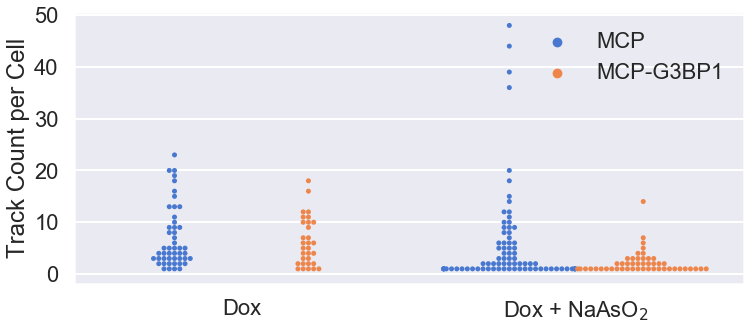

In [11]:
# Cellular count
df_plot = df_cells

# Style
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})
sns.set(context='poster', font='Arial', style='darkgrid', palette='muted')

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.swarmplot(x='induction',
              y='Tracks_per_cell',
              hue='condition',
              dodge=True,
              data=df_plot,
              order=['Dox', 'DoxArs'],
              hue_order=['MCP', 'MCP-G3BP1'])

# Display
ax.set(xlabel='', ylabel='Track Count per Cell')
ax.set_xticklabels(['Dox', 'Dox + NaAsO$_2$'])
ax.set_yticks(np.arange(0, 51, step=10))
ax.legend(frameon=False, loc='upper right')

# Saving
plt.savefig('./plots/MCP_SunTag_Count_cell.pdf', bbox_inches='tight')
plt.show()

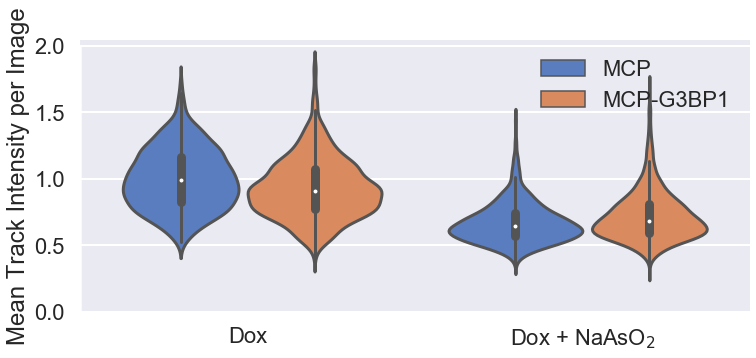

In [12]:
# Image intensity
df_plot = df_images

# Style
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})
sns.set(context='poster', font='Arial', style='darkgrid', palette='muted')

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.violinplot(x='induction',
                   y='rel_track',
                   hue='condition',
                   dodge=True,
                   data=df,
                   order=['Dox', 'DoxArs'],
                   hue_order=['MCP', 'MCP-G3BP1'])

# Display
ax.set(xlabel='', ylabel='Mean Track Intensity per Image')
ax.set_xticklabels(['Dox', 'Dox + NaAsO$_2$'])
ax.set_yticks(np.arange(0, 2.1, step=0.5))
ax.legend(frameon=False, loc='upper right')
sns.despine(left=False, bottom=True, trim=True)

# Saving
plt.savefig('./plots/MCP_SunTag_Int_img.pdf', bbox_inches='tight')
plt.show()

## Figure 5 – MCP TREAT

Ctd. TREAT measurements at different timepoints after induction.

**Processing**

In [13]:
def find_condition(file):
    if 'MCPG3_' in file:
        return 'MCPG3'
    return 'MCP'

# Misslabeling during imaging
def find_timepoint(file, condition):
    if condition == 'MCP':
        if '_0h_' in file:
            return 0
        if '_0-5h_' in file:
            return 0.5
        if '_1h_' in file:
            return 1
        if '_2h_' in file:
            return 2
        if '_4h_' in file:
            return 4
    if condition == 'MCPG3':
        if '_negh_' in file:
            return 0
        if '_0h_' in file:
            return 0.5
        if '_0-5h_' in file:
            return 1
        if '_1h_' in file:
            return 2
        if '_2h_' in file:
            return 4

In [14]:
# Cellular level

# Reading
df = pd.read_csv(f'./data/MCP_TREAT_data_cells.csv', index_col=0)

# Condition <- File
df['condition'] = df['file'].apply(lambda x: find_condition(x))

# Timepoint <- File
index_mcp = df[df['condition'] == 'MCP'].index
index_mcpg3 = df[df['condition'] == 'MCPG3'].index
df.loc[index_mcp, 'timepoint'] = df['file'].apply(lambda x: find_timepoint(x, 'MCP'))
df.loc[index_mcpg3, 'timepoint'] = df['file'].apply(lambda x: find_timepoint(x, 'MCPG3'))

# Filtering
df['spot_density'] = df['blobs_cytoplasm_c2']/df['cytoplasm_area']
df = df[(df['nucleus_area'] > 1e3) &
        (df['cytoplasm_area'] > 1e3) &
        (df['cytoplasm_area'] < 1e5) &
        (df['blobs_cytoplasm_c2'] > 10) &
        (df['spot_density'] < 0.1)]
df = df.reset_index(drop=True)
pos_cells = df['file'].astype(str) + '-' + df['cell'].astype(str)

# Calculations
df['nucleus_fraction_c1'] = df['blobs_nucleus_c1']/(df['blobs_nucleus_c1']+df['blobs_cytoplasm_c1'])
df['cytosol_fraction_c1'] = df['blobs_cytoplasm_c1']/(df['blobs_nucleus_c1']+df['blobs_cytoplasm_c1'])
df['nucleus_fraction_c2'] = df['blobs_nucleus_c2']/(df['blobs_nucleus_c2']+df['blobs_cytoplasm_c2'])
df['cytosol_fraction_c2'] = df['blobs_cytoplasm_c2']/(df['blobs_nucleus_c2']+df['blobs_cytoplasm_c2'])

print(df.groupby(['condition', 'timepoint'])['nucleus_fraction_c2'].count())

df_cells = df

condition  timepoint
MCP        0.0          145
           0.5          173
           1.0          218
           2.0          205
           4.0          183
MCPG3      0.0          151
           0.5          178
           1.0          202
           2.0          186
           4.0          233
Name: nucleus_fraction_c2, dtype: int64


In [15]:
# Spot level

# Reading
df = pd.read_csv(f'./data/MCP_TREAT_data_blobs.csv', index_col=0)

# Condition <- File
df['condition'] = df['file'].apply(lambda x: find_condition(x))

# Timepoint <- File
index_mcp = df[df['condition'] == 'MCP'].index
index_mcpg3 = df[df['condition'] == 'MCPG3'].index
df.loc[index_mcp, 'timepoint'] = df['file'].apply(lambda x: find_timepoint(x, 'MCP'))
df.loc[index_mcpg3, 'timepoint'] = df['file'].apply(lambda x: find_timepoint(x, 'MCPG3'))

# Filtering
df['uuid'] = df['file'].astype(str) + '-' + df['cell'].astype(str)
df = df[df['uuid'].isin(pos_cells)]
df['intact'] = (df['dist'] < 2) &\
                     (df['dist'] != -1)
df['cell_intact'] = df.groupby(['direction', 'uuid', 'nuclear'])['intact'].transform('mean')
df = df.reset_index(drop=True)

# Normalization
agg_funcs = {'condition': 'first', 'timepoint': 'first', 'cell_intact': 'mean'}
norm = df[df['direction'] == 12].groupby(['uuid'])['cell_intact'].mean()

df_blobs = df

**Plotting**

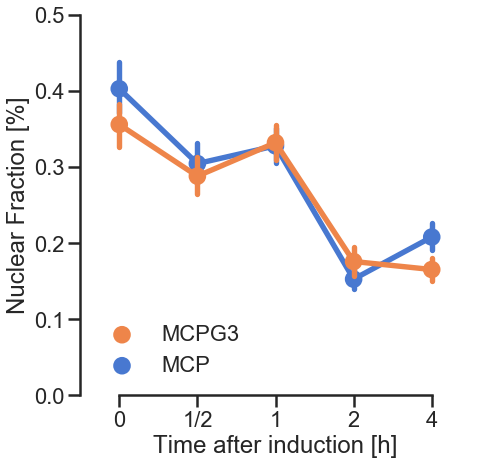

In [16]:
# Cell level
df_plot = df_cells

# Style
sns.set(context='poster', font='Arial', style='whitegrid', palette='muted')
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.pointplot(x='timepoint',
                   y='nucleus_fraction_c2',
                   hue='condition',
                   hue_order=['MCP', 'MCPG3'],
                   data=df_plot)

# Display
ax.set_xlabel('Time after induction [h]')
ax.set_ylabel('Nuclear Fraction [%]')
ax.set_ylim(0, 0.5)
ax.set_xticklabels(['0', '1/2', '1', '2', '4'])
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc='lower left')
sns.despine(left=False, bottom=False, trim=True)

plt.savefig('./plots/MCP_TREAT_nuc_fraction.pdf', bbox_inches='tight')
plt.show()

condition  timepoint
MCP        0.0          117
           0.5          154
           1.0          200
           2.0          175
           4.0           55
MCPG3      0.0          114
           0.5          148
           1.0          167
           2.0          111
           4.0          132
Name: cell_intact, dtype: int64
pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2_MCP v.s. 2_MCPG3: t-test independent samples, P_val=1.361e-03 stat=-3.235e+00
4_MCP v.s. 4_MCPG3: t-test independent samples, P_val=5.599e-08 stat=-5.663e+00


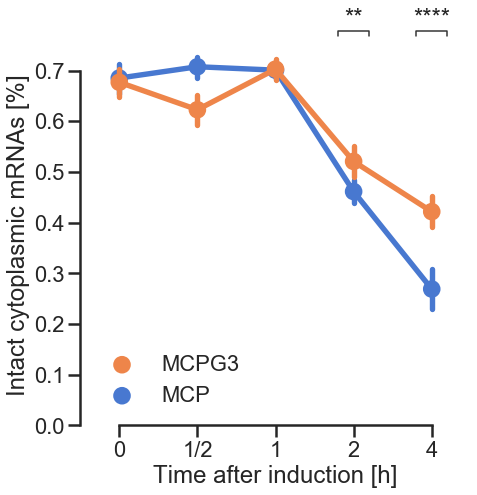

In [17]:
# Spot level
df_plot = df_blobs

# Style
sns.set(context='poster', font='Arial', style='whitegrid', palette='muted')
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})

# Filtering
df_plot = df[(df['direction'] == 21) &
#              (df_plot['nuclear'] == True)]\
             (df_plot['nuclear'] == False)]\
             .groupby('uuid', as_index=False)\
             .aggregate(agg_funcs)\
             .reindex(columns=['uuid', 'condition', 'timepoint', 'cell_intact'])
df_plot['norm'] = df_plot['uuid'].map(norm)
df_plot = df_plot[df_plot['norm']>0.5]
print(df_plot.groupby(['condition', 'timepoint'])['cell_intact'].count())

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.pointplot(x='timepoint',
                   y='cell_intact',
                   hue='condition',
                   hue_order=['MCP', 'MCPG3'],
                   data=df_plot)

# Statistics
statannot.add_stat_annotation(ax, data=df_plot,
                              x='timepoint', y='cell_intact', hue='condition',
                              boxPairList=[((2, 'MCP'), (2, 'MCPG3')),
                                           ((4, 'MCP'), (4, 'MCPG3'))],
                              test='t-test_ind', loc='outside', verbose=1, stack=False)

# Display
ax.set_xlabel('Time after induction [h]')
# ax.set_ylabel('Intact nuclear mRNAs [%]')
ax.set_ylabel('Intact cytoplasmic mRNAs [%]')
ax.set_ylim(0)
ax.set_xticklabels(['0', '1/2', '1', '2', '4'])
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], frameon=False, loc='lower left')
sns.despine(left=False, bottom=False, trim=True)

# plt.savefig('./plots/MCP_TREAT_nuc_decay.pdf', bbox_inches='tight')
plt.savefig('./plots/MCP_TREAT_cyt_decay.pdf', bbox_inches='tight')
plt.show()

## Figure 6 – Spaghetti Monster

SunTag comparison. Comparing the standard SunTag with the new spaghetti monster GFP SunTag. Both induction efficiency and spot intensity are compared.

**Processing**

In [18]:
# Induction

# Reading
df = pd.read_csv('./data/Induction_smGFP.csv')
df = df.dropna()

# Data rearangement
pim_count = []
smg_count = []

for n, row in df.iterrows():
    
    if row['Condition'] == 'pIM52':
        for i in range(row['Non-induced']):
            pim_count.append(0)
            
        induced = row['Induced']
        if len(induced) == 0:
            continue
        elif len(induced) == 1:
            pim_count.append(int(induced))
        else:
            induced = induced.split(',')
            for i in induced:
                pim_count.append(int(i))
                
    else:
        for i in range(row['Non-induced']):
            smg_count.append(0)
            
        induced = row['Induced']
        if len(induced) == 0:
            continue
        elif len(induced) == 1:
            smg_count.append(int(induced))
        else:
            induced = induced.split(',')
            for i in induced:
                smg_count.append(int(i))
                
# Merging
pim = pd.DataFrame([['Standard' for _ in pim_count], pim_count]).T
smg = pd.DataFrame([['smGFP' for _ in smg_count], smg_count]).T
df = pd.concat([pim, smg])
df.columns = ['condition', 'value']

# Filtering
df = df[df['value'] < 20]
df['value'] = df['value'].astype(float)

df_induction = df

In [19]:
# Intensity

# Reading
pim = pd.read_csv('./data/Intensity_Standard.csv')
pim['condition'] = 'Standard'
smg = pd.read_csv('./data/Intensity_smGFP.csv')
smg['condition'] = 'smGFP'

# Merging
df = pd.concat([smg, pim])
df['norm'] = df['Mean'] / df[df['condition'] == 'smGFP']['Mean'].mean()

df_intensity = df

**Plotting**

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Standard v.s. smGFP: t-test independent samples, P_val=1.710e-20 stat=-9.684e+00


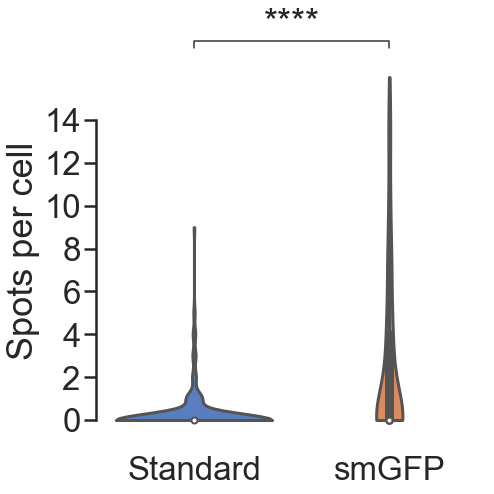

In [20]:
# Induction
df_plot = df_induction

# Style
sns.set(context='poster', font='Arial', font_scale=1.5, style='whitegrid', palette='muted')
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})

# Plot
fig, ax = plt.subplots(figsize=(7, 7))
ax = sns.violinplot(x='condition',
                    y='value',
                    cut=0,
                    data=df_plot)

# Statistics
statannot.add_stat_annotation(ax, data=df_plot,
                              x='condition', y='value',
                              boxPairList=[('Standard', 'smGFP')],
                              test='t-test_ind', loc='outside', verbose=1, stack=False)

# Display
ax.set_xlabel('')
ax.set_ylabel('Spots per cell')
ax.set_yticks(np.arange(0, 15, 2))
ax.tick_params(bottom=False)
sns.despine(left=False, bottom=True, trim=True)

# Saving
plt.savefig('./plots/smGFP_induction.pdf', bbox_inches='tight')
plt.show()

pvalue annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Standard v.s. smGFP: t-test independent samples, P_val=3.653e-09 stat=6.705e+00


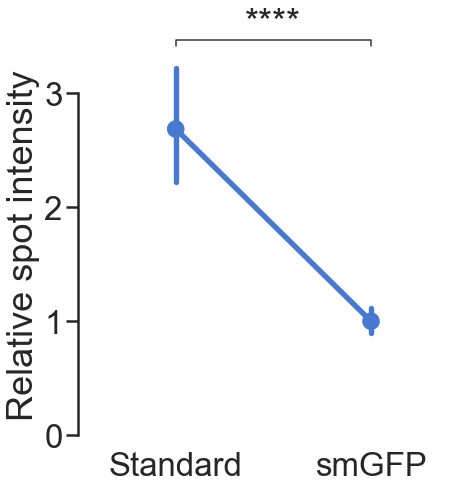

In [21]:
# Intensity
df_plot = df_intensity

# Style
sns.set(context='poster', font='Arial', font_scale=1.5, style='whitegrid', palette='muted')
sns.set_style('ticks', {'xtick.major.size': 0, 'ytick.major.size': 0})

# Plot
fig, ax = plt.subplots(figsize=(7, 7)) 
ax = sns.pointplot(x='condition',
                   y='norm',
                   order=['Standard', 'smGFP'],
                   data=df_plot)

# Statistics
statannot.add_stat_annotation(ax, data=df_plot,
                              x='condition', y='norm',
                              boxPairList=[('Standard', 'smGFP')],
                              test='t-test_ind', loc='outside', verbose=1, stack=False)

# Display
ax.set_xlabel('')
ax.set_ylabel('Relative spot intensity')
ax.set_ylim(0)
ax.set_yticks(np.arange(0, 4, 1))
ax.tick_params(bottom=False)
sns.despine(left=False, bottom=True, trim=True)

plt.savefig('./plots/smGFP_intensity.pdf', bbox_inches='tight')
plt.show()